# [GD-02] 이미지 어디까지 우려볼까? 


### 목차 

    (1) 라이브러리 import 및 버전 확인
    (2) 데이터 준비 / 전처리
    (3) 모델 구성하기
    (4) 모델 학습하기 
    (5) 시각화

### (1) 라이브러리 import


In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds



In [2]:
print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# image 전처리 함수
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# Basic augmentation(좌우반전, 명도변화)
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

'''Cut Mix'''
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = 224
    image_size_y = 224
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = 224
    image_size_y = 224
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

'''Mixup'''
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_a = image[i]
        image_b = image[idx]
        label_a = label[i]
        label_b = label[idx]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    
    if not is_test and with_aug: # basic augmentation
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix: # cutmix
        ds = ds.map(cutmix, num_parallel_calls=2)
    elif not is_test and with_mixup: # mixup
        ds = ds.map(mixup, num_parallel_calls=2)
    else:
        ds = ds.map(onehot, num_parallel_calls=2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### (2) 데이터 준비 & 전처리 

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

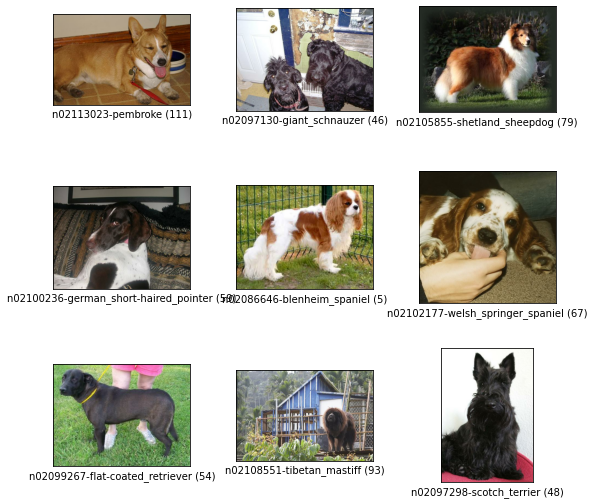

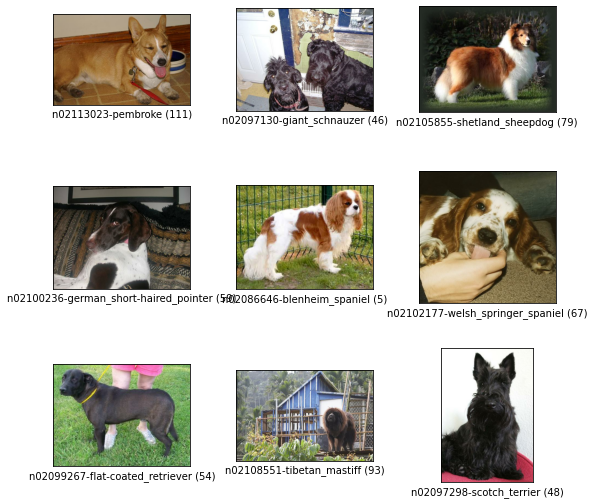

In [6]:
tfds.show_examples(ds_train, ds_info)

In [7]:
num_classes = ds_info.features["label"].num_classes

In [8]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cut = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mix = apply_normalize_on_dataset(ds_train, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### (3) 모델 구성하기

- No augmentation
- Basic augmentation
- Cutmix
- Mixup 

In [9]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


In [10]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


In [11]:
cut_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [12]:
mix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### (4) 모델 학습

- No augmentation
- Basic augmentation
- Cutmix
- Mixup 

In [13]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

In [14]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate =0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 168s 210ms/step - loss: 2.2153 - accuracy: 0.4444 - val_loss: 3.4350 - val_accuracy: 0.1982
Epoch 2/20
750/750 [==============================] - 156s 209ms/step - loss: 0.7480 - accuracy: 0.7909 - val_loss: 1.1093 - val_accuracy: 0.6768
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 0.2643 - accuracy: 0.9422 - val_loss: 1.0147 - val_accuracy: 0.7023
Epoch 4/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0819 - accuracy: 0.9896 - val_loss: 0.9323 - val_accuracy: 0.7306
Epoch 5/20
750/750 [==============================] - 171s 229ms/step - loss: 0.0296 - accuracy: 0.9987 - val_loss: 0.9202 - val_accuracy: 0.7350
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0176 - accuracy: 0.9991 - val_loss: 0.9281 - val_accuracy: 0.7361
Epoch 7/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0127 - accuracy: 0.9997 - val_loss: 0.9394 -

In [15]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 164s 210ms/step - loss: 2.2742 - accuracy: 0.4287 - val_loss: 3.2819 - val_accuracy: 0.2444
Epoch 2/20
750/750 [==============================] - 157s 209ms/step - loss: 0.9436 - accuracy: 0.7317 - val_loss: 1.2290 - val_accuracy: 0.6465
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 0.5012 - accuracy: 0.8580 - val_loss: 1.0671 - val_accuracy: 0.6917
Epoch 4/20
750/750 [==============================] - 157s 209ms/step - loss: 0.2754 - accuracy: 0.9327 - val_loss: 1.0964 - val_accuracy: 0.6889
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 0.1840 - accuracy: 0.9599 - val_loss: 1.0862 - val_accuracy: 0.6927
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0934 - accuracy: 0.9838 - val_loss: 1.0064 - val_accuracy: 0.7227
Epoch 7/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0556 - accuracy: 0.9918 - val_loss: 1.0484 -

In [16]:
cut_resnet50.compile(
    loss= 'categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cut_aug = cut_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 165s 211ms/step - loss: 2.2902 - accuracy: 0.4254 - val_loss: 3.1805 - val_accuracy: 0.2559
Epoch 2/20
750/750 [==============================] - 171s 229ms/step - loss: 0.9561 - accuracy: 0.7288 - val_loss: 1.3142 - val_accuracy: 0.6208
Epoch 3/20
750/750 [==============================] - 157s 210ms/step - loss: 0.5038 - accuracy: 0.8602 - val_loss: 1.1206 - val_accuracy: 0.6697
Epoch 4/20
750/750 [==============================] - 157s 210ms/step - loss: 0.2586 - accuracy: 0.9362 - val_loss: 1.1051 - val_accuracy: 0.6842
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 0.1495 - accuracy: 0.9695 - val_loss: 1.0315 - val_accuracy: 0.7122
Epoch 6/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0806 - accuracy: 0.9883 - val_loss: 1.0516 - val_accuracy: 0.7149
Epoch 7/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0516 - accuracy: 0.9933 - val_loss: 1.0263 -

In [17]:
mix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_mix_aug = mix_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 165s 211ms/step - loss: 2.2915 - accuracy: 0.4268 - val_loss: 3.6960 - val_accuracy: 0.1692
Epoch 2/20
750/750 [==============================] - 157s 210ms/step - loss: 0.9747 - accuracy: 0.7193 - val_loss: 1.2363 - val_accuracy: 0.6449
Epoch 3/20
750/750 [==============================] - 157s 210ms/step - loss: 0.5381 - accuracy: 0.8494 - val_loss: 1.1289 - val_accuracy: 0.6683
Epoch 4/20
750/750 [==============================] - 157s 209ms/step - loss: 0.2805 - accuracy: 0.9317 - val_loss: 1.0816 - val_accuracy: 0.6920
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 0.1480 - accuracy: 0.9711 - val_loss: 1.0063 - val_accuracy: 0.7128
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0854 - accuracy: 0.9874 - val_loss: 0.9606 - val_accuracy: 0.7352
Epoch 7/20
750/750 [==============================] - 157s 209ms/step - loss: 0.0605 - accuracy: 0.9919 - val_loss: 0.9967 -

### (5) 시각화 하기

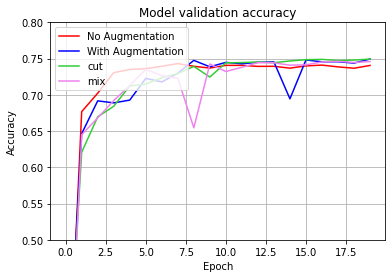

In [18]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_cut_aug.history['val_accuracy'], color='limegreen')
plt.plot(history_mix_aug.history['val_accuracy'], color='violet')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','cut','mix'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

# 회고 


### 목표 

|       |                                    **< 평가문항 >**                                   |                                                              **< 상세기준 >**                                                             |
|-------|:---------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| **1** | CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?                         | CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다                                                   |
| **2** | 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가? | Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함      |
| **3** |  여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?      | 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.
|


<br> 

- 다양한 Augmentation 기법을 적용하여 ResNet-50 를 학습시켜 보는 과제였는데 어렵지만 무척 재미있었다. 개인적으로 아이펠톤을 위해 꼭 배워두고 싶었던 주제였고 다양하게 시도해 볼 수 있어 매우 유익한 학습이었다. 


- 결과는 마지막 시각화 그래프에 잘 나타나 있는데, epoch 11 정도를 기점으로 with augmentation, cut, mix 의 validation accuracy 가 no augmentation 모델 보다 높아졌고 그러한 추세가 계속 이어졌다. 그렇다고 하더라도 4개 모델의 accuracy 가 큰 차이가 나지는 않고 0.75 근처로 수렴하는데 이미 훈련이 된 모델이기 때문이라 그런 것 같다. 


- 시간이 좀 더 여유가 있었다면 epoch 값을 다양하게 시도해서 성능을 좀 더 확실히 확인할 수 있었을 것 같다. 아이펠톤에 필요한 기법이니 시간여유가 될 때 복습을 해보도록 해야겠다 
